# ECON 6760 Time Series Project

## The Causal Effects of Climate Change on Housing Prices

### Data Preparation

In [146]:
# Import packages
import pandas as pd
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
import requests
from tabulate import tabulate
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

In [147]:
# Temperature data upload and cleaning
temp_data = pd.read_csv('temp_data.csv', skiprows=4)
temp_data = temp_data.rename({'Value':'Anomaly','Year':'Date'}, axis=1)
temp_data['Date'] = pd.to_datetime(temp_data['Date'], format='%Y%m')
temp_data = temp_data.set_index('Date')
temp_data = temp_data.resample('6M').mean()
temp_data = temp_data.reset_index()
temp_data['Date'] = temp_data['Date'].dt.strftime('%Y-%m')
temp_data = temp_data.iloc[:-2]

In [148]:
# Housing price data upload and cleaning
house_data = pd.read_csv('MSPUS.csv')
house_data = house_data.rename({'MSPUS':'Median Price','DATE':'Date'}, axis=1)
house_data['Date'] = pd.to_datetime(house_data['Date'])
house_data['Date'] = house_data['Date'].dt.strftime('%Y-%m')
house_data = house_data.iloc[4:]

In [149]:
# Create basic time series plots
temp_plot = alt.Chart(temp_data).mark_line().encode(
    x=alt.X('Date:T', axis=alt.Axis(labelAngle=-45, grid=False)),
    y='Anomaly'
).properties(
    title='Temperature Anomaly Over Time'
)

house_plot = alt.Chart(house_data).mark_line().encode(
    x=alt.X('Date:T', axis=alt.Axis(labelAngle=-45, grid=False)),
    y='Median Price'
).properties(
    title='Housing Prices Over Time'
)

house_plot | temp_plot

alt.HConcatChart(...)

In [150]:
# Join the two datasets
data = temp_data.merge(house_data)
data['ln(Median Price)'] = np.log(data['Median Price'])
data.set_index('Date', inplace=True)
anomalies = data['Anomaly']
prices = data['ln(Median Price)']
data.head()

,Anomaly,Median Price,ln(Median Price)
Date,,,
1965-01,-0.090000,20000.0,9.903488
1965-07,-0.106667,20250.0,9.915910
1966-01,-0.030000,21550.0,9.978131
1966-07,-0.008333,21450.0,9.973480
1967-01,-0.031667,22800.0,10.034516


### ARDL Model

In [151]:
# ARDL Model
exog = data[['Anomaly']]
ardl_model = ARDL(prices, 0, exog, 2, causal=True)
ardl_results = ardl_model.fit()
print(ardl_results.summary())

                              ARDL Model Results                              
Dep. Variable:       ln(Median Price)   No. Observations:                  116
Model:                     ARDL(0, 2)   Log Likelihood                 -28.180
Method:               Conditional MLE   S.D. of innovations              0.309
Date:                Wed, 26 Apr 2023   AIC                             64.361
Time:                        19:06:38   BIC                             75.375
Sample:                    01-01-1966   HQIC                            68.832
                         - 07-01-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5789      0.049    213.793      0.000      10.481      10.677
Anomaly.L1     1.3131      0.309      4.249      0.000       0.701       1.925
Anomaly.L2     1.2849      0.309      4.156      0.0

/Users/danielsaul/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2QS-OCT will be used.
  self._init_dates(dates, freq)


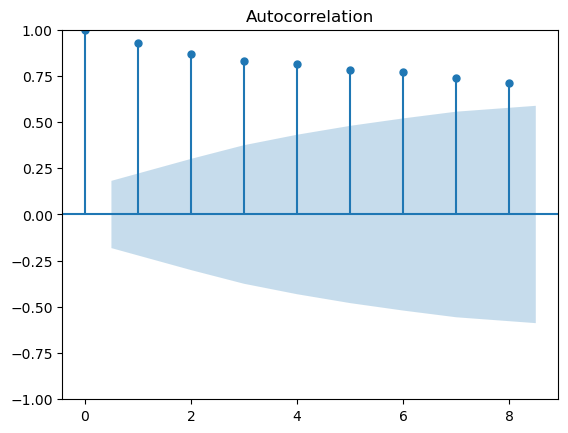

In [152]:
plot_acf(anomalies, lags=8)
plt.show()

##### Forecast X_t

In [153]:
ar_model = AutoReg(endog=anomalies, exog=None, lags=6)
ar_results = ar_model.fit()

print(ar_results.summary())

                            AutoReg Model Results                             
Dep. Variable:                Anomaly   No. Observations:                  116
Model:                     AutoReg(6)   Log Likelihood                 115.790
Method:               Conditional MLE   S.D. of innovations              0.084
Date:                Wed, 26 Apr 2023   AIC                           -215.581
Time:                        19:06:39   BIC                           -193.977
Sample:                    01-01-1968   HQIC                          -206.818
                         - 07-01-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0246      0.014      1.742      0.082      -0.003       0.052
Anomaly.L1     0.7953      0.089      8.906      0.000       0.620       0.970
Anomaly.L2    -0.1296      0.115     -1.129      0.2

/Users/danielsaul/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2QS-OCT will be used.
  self._init_dates(dates, freq)


In [154]:
forecast_log_pred = ar_results.forecast(12)
forecast_log_pred.index = forecast_log_pred.index.strftime('%Y-%m')
all_X = anomalies.append(forecast_log_pred)

/Users/danielsaul/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/var/folders/51/h1nmh05j5mz75s5kwn0ngjxr0000gn/T/ipykernel_44702/986708065.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_X = anomalies.append(forecast_log_pred)


In [155]:
# Generate forecasts of x using the AR model
residual_variance = np.var(ar_results.resid)
prediction_interval_variance = np.arange(1, len(forecast_log_pred)+1) * residual_variance
forecast_log_pred_lower = forecast_log_pred - 1.96*np.sqrt(prediction_interval_variance)
forecast_log_pred_upper = forecast_log_pred + 1.96*np.sqrt(prediction_interval_variance)

In [156]:
x_intervals = pd.concat([forecast_log_pred, forecast_log_pred_lower, forecast_log_pred_upper], axis=1)
x_intervals = x_intervals.rename({0:'Forecast Value', 1:'Lower Bound', 2:'Upper Bound'}, axis=1)
x_intervals.index.names = ['Date']
print(x_intervals.to_markdown())

| Date    |   Forecast Value |   Lower Bound |   Upper Bound |
|:--------|-----------------:|--------------:|--------------:|
| 2023-01 |         0.95111  |      0.785585 |       1.11663 |
| 2023-07 |         0.977485 |      0.743397 |       1.21157 |
| 2024-01 |         1.00019  |      0.713495 |       1.28689 |
| 2024-07 |         0.956732 |      0.625682 |       1.28778 |
| 2025-01 |         0.955976 |      0.585851 |       1.3261  |
| 2025-07 |         0.965176 |      0.559724 |       1.37063 |
| 2026-01 |         0.985914 |      0.547977 |       1.42385 |
| 2026-07 |         0.991242 |      0.523067 |       1.45942 |
| 2027-01 |         1.01076  |      0.514182 |       1.50733 |
| 2027-07 |         1.01122  |      0.487787 |       1.53466 |
| 2028-01 |         1.01251  |      0.463529 |       1.5615  |
| 2028-07 |         1.01136  |      0.437967 |       1.58476 |


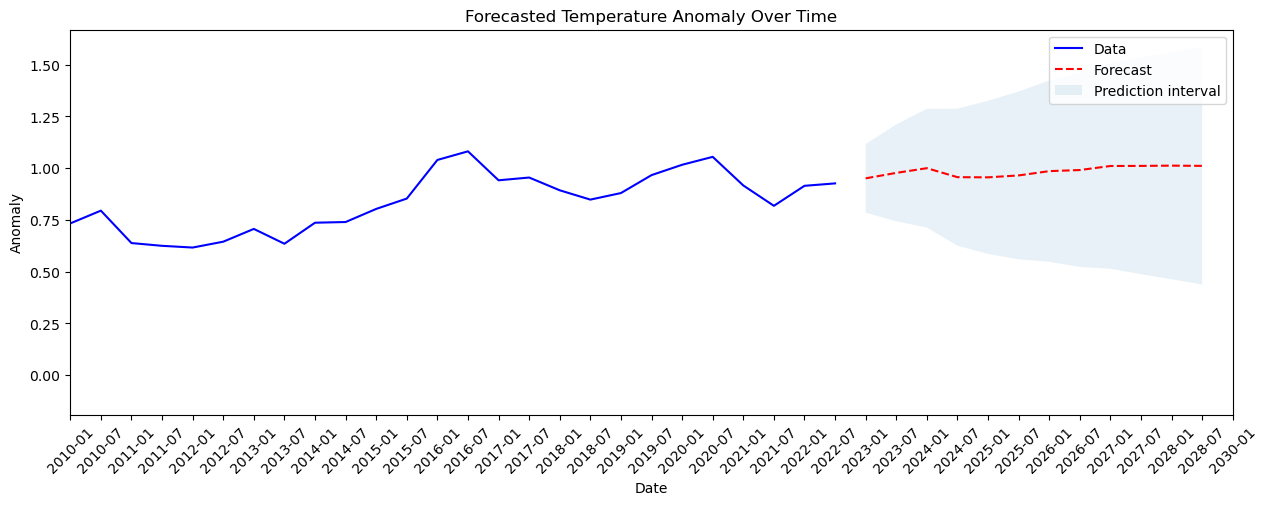

In [160]:
plt.figure(figsize=(15,5))
plt.plot(anomalies.index, anomalies.values, color='blue', label='Data')
plt.plot(forecast_log_pred.index, forecast_log_pred, linestyle='dashed', color='red', label='Forecast')
plt.fill_between(forecast_log_pred.index, forecast_log_pred_lower, forecast_log_pred_upper, 
        label='Prediction interval', alpha=.1)

plt.legend()
plt.title('Forecasted Temperature Anomaly Over Time')
plt.ylabel('Anomaly')
plt.xlabel('Date')
#plt.tick_params(rotation=45)
plt.xticks(rotation=45)
plt.xlim(['2010-01', '2030-01'])
plt.show()

### Forecast Y_t

In [136]:
data.index = pd.to_datetime(data[['ln(Median Price)']].index)
forecast_log_pred.index.names = ['Date']
forecast_log_pred.index = pd.to_datetime(forecast_log_pred.index)
forecast_x_df = pd.DataFrame(forecast_log_pred).rename({0:'Anomaly'}, axis=1)

In [168]:
forecast_y = ardl_results.get_prediction(start='2023-01-01', end='2028-07-01', exog=data[['Anomaly']], exog_oos=forecast_x_df, dynamic=True)

y_conf = forecast_y.conf_int().rename({'lower':'Lower Bound', 'upper':'Upper Bound'}, axis=1)
y_conf['Forecast Value'] = forecast_y.predicted_mean
y_conf = y_conf[['Forecast Value', 'Lower Bound', 'Upper Bound']]
y_conf.index = y_conf.index.strftime('%Y-%m')
y_conf.index.names = ['Date']


print(y_conf.to_markdown())

| Date    |   Forecast Value |   Lower Bound |   Upper Bound |
|:--------|-----------------:|--------------:|--------------:|
| 2023-01 |          12.9714 |       12.3668 |       13.5761 |
| 2023-07 |          13.0185 |       12.4139 |       13.6232 |
| 2024-01 |          13.0846 |       12.4799 |       13.6892 |
| 2024-07 |          13.1483 |       12.5436 |       13.7529 |
| 2025-01 |          13.1204 |       12.5157 |       13.7251 |
| 2025-07 |          13.0635 |       12.4589 |       13.6682 |
| 2026-01 |          13.0747 |       12.47   |       13.6793 |
| 2026-07 |          13.1137 |       12.509  |       13.7184 |
| 2027-01 |          13.1474 |       12.5427 |       13.752  |
| 2027-07 |          13.1798 |       12.5752 |       13.7845 |
| 2028-01 |          13.2055 |       12.6008 |       13.8102 |
| 2028-07 |          13.2078 |       12.6031 |       13.8125 |


/Users/danielsaul/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


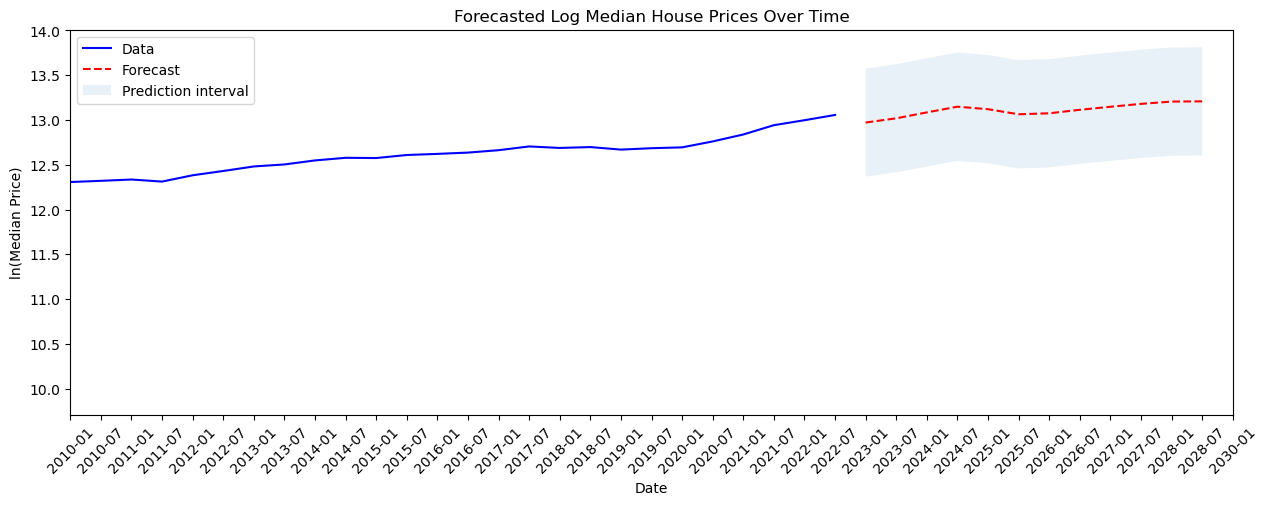

In [169]:
plt.figure(figsize=(15,5))
plt.plot(data.index, data['ln(Median Price)'], color='blue', label='Data')
plt.plot(y_conf.index, y_conf['Forecast Value'], linestyle='dashed', color='red', label='Forecast')
plt.fill_between(y_conf.index, y_conf['Lower Bound'], y_conf['Upper Bound'], 
        label='Prediction interval', alpha=.1)

plt.legend()
plt.title('Forecasted Log Median House Prices Over Time')
plt.ylabel('ln(Median Price)')
plt.xlabel('Date')
#plt.tick_params(rotation=45)
plt.xticks(rotation=45)
plt.xlim(['2010-01', '2030-01'])
plt.show()